In [1]:
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from random import randint
import scipy.cluster.hierarchy as hcluster

In [2]:
def get_nonzero(image):
    nonzero_x = np.nonzero(255 - image)[0]
    nonzero_y = np.nonzero(255 - image)[1]
    pairs = np.vstack((nonzero_x, nonzero_y)).T
    return pairs

In [3]:
def choice(pixels):
    n = len(pixels)
    idx1 = randint(0, n - 1)
    pixel1 = pixels[idx1]
    idx2 = randint(0, n - 1)
    if (idx2 == idx2):
        idx2 = (idx2 + 1) % n
    pixel2 = pixels[idx2]
    return (pixel1, pixel2)

In [4]:
def random_radon_transformation(image, rho_steps = 220, theta_steps = 440, n_iter = int(1e5)):

    nonzero_pixels = get_nonzero(image)

    a = image.shape[1]
    b = image.shape[0]

    n_rhos = 2 * rho_steps
    n_thetas = theta_steps

    rho_max = np.sqrt(a ** 2 + b ** 2)
    rho_step = rho_max / rho_steps
    theta_step = np.pi / n_thetas
    
    R = np.zeros((n_rhos, n_thetas), dtype='float64')
    for i in range(n_iter):
        pixel1, pixel2 = choice(nonzero_pixels)

        x_1 = pixel1[0]
        y_1 = pixel1[1]
        x_2 = pixel2[0]
        y_2 = pixel2[1]

        theta = np.pi / 2
        if (y_1 != y_2):
            theta = np.arctan((x_2 - x_1) / (y_1 - y_2))
        if (theta < 0):
            theta = np.pi + theta
        rho = x_1 * np.cos(theta) + y_1 * np.sin(theta)

        rho += rho_max 

        theta_int = int(theta / theta_step)
        rho_int = int(rho / rho_step)
        R[rho_int][theta_int] += 1

    m = np.max(np.unique(R))
    R *= (255/m)
    return R

In [5]:
def generate_line_points(im_len, k, b, thickness=1):

    x = np.array([], 'int64')
    y = np.array([], 'int64')
    
    for i in range(0, thickness):
        
        x_i = np.arange(0, im_len, 1)
        y_i = k * x_i + b + i
        points = [(x_i[j], y_i[j]) for j in range(im_len)]
        filtered_points = np.array(list(filter(lambda x: (x[1] >= 0) * (x[1] < im_len), points)))
        if (filtered_points.shape[0] != 0):
            x_i = filtered_points[:, 0]
            y_i = filtered_points[:, 1]
            x = np.hstack([x, x_i])
            y = np.hstack([y, y_i])
    return x, y

In [6]:
def generate_line_points_angle(im_len, r, theta, thickness=1):
    x = np.array([], 'int64')
    y = np.array([], 'int64')
    x0 = y0 = im_len//2
    
    for i in range(0, thickness):
        x_i = np.array([])
        y_i = np.array([])
        if (abs(theta - np.pi / 2) < 1e-4):
            x_i = np.array([x0 + i] * im_len)
            y_i = np.arange(0, im_len, 1)
            x = np.hstack([x, x_i])
            y = np.hstack([y, y_i])
        else:
            x_i = np.arange(0, im_len, 1)
            y_i = np.array(y0 + r/(math.cos(theta)) + (x_i-x0)*math.tan(theta)).astype('int')+i
            points = [(x_i[j], y_i[j]) for j in range(im_len)]
            filtered_points = np.array(list(filter(lambda pixel: (pixel[1]>=0)*(pixel[1]<im_len), points)))
            if (filtered_points.shape[0] != 0):
                x_i = filtered_points[:, 0]
                y_i = filtered_points[:, 1]
                x = np.hstack([x, x_i])
                y = np.hstack([y, y_i])
    return x, y

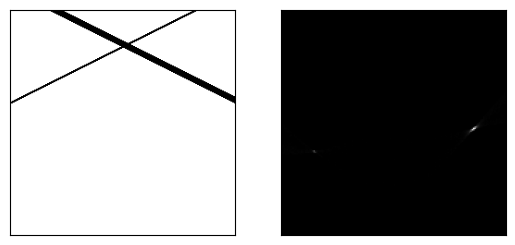

In [9]:
im_len = 244
x_points, y_points = generate_line_points(im_len, k = 2, b = 40, thickness=15)

x_points_2, y_points_2 = generate_line_points(im_len, k =-2, b =200, thickness=5)
img = np.zeros((im_len, im_len), dtype=np.uint8)
img[x_points, y_points] = 255
img[x_points_2, y_points_2] = 255
img = 255 - img

steps = 80
radon = random_radon_transformation(img, rho_steps=steps, theta_steps=steps * 2, n_iter=int(1e4))

plt.subplot(1, 2, 1), plt.imshow(img, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2), plt.imshow(radon, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [48]:
def reversed_random_radon_transformation(R, n_iter=int(1e4)):
    im_len = R.shape[0]
    RR = np.zeros((im_len, im_len))
    # x = np.array([], 'int64')
    # y = np.array([], 'int64')
    # reR = np.apply_over_axes(lambda pixel: generate_line_points(im_len, pixel[0], y, thickness=pixel[1])*radon[R[x], R[y]], R, axes = [0,1])
    for i in range(n_iter):
        nonzero_pixels = get_nonzero(R)
        pixel= choice(nonzero_pixels)
        
        k = pixel[0]
        b = pixel[1]

        x_points, y_points = generate_line_points(im_len, k, b)
        filtered_points = np.array(list(filter(lambda pixel: (pixel[1]>=0)*(pixel[1]<im_len), points)))
        
        for i in len(filtered_points[0]):
            RR[x_points[i]][y_points[i]] = max(RR[x_points[i]][y_points[i]], R[k][b])
        
        return RR

In [49]:
im_len = 244
x_points, y_points = generate_line_points(im_len, k = 2, b = 40, thickness=15)

x_points_2, y_points_2 = generate_line_points(im_len, k =-2, b =200, thickness=5)
img = np.zeros((im_len, im_len), dtype=np.uint8)
img[x_points, y_points] = 255
img[x_points_2, y_points_2] = 255
img = 255 - img

steps = 80

reradon = reversed_random_radon_transformation(radon)

plt.subplot(1, 2, 2), plt.imshow(reradon, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

ValueError: operands could not be broadcast together with shapes (2,) (160,) 